<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Feature_selection_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  2 15:15:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [46]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import seaborn as sns

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# memory management
import gc
import re
import timeit #pour mesurer le temps déxécution
#permet de stocker notre modéle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# modeling 
import lightgbm as lgb
import sklearn.metrics as me
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV 
#pour avoir le tableau f1,precision
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.metrics import classification_report

In [3]:
def Histo(colonne,base,bines):
  sns.displot(x=colonne,data=base, kde=False, bins=bines,color="darkblue")
  plt.grid()

In [45]:
def conf_mat_transform(y_test,y_pred) :
    conf_mat = me.confusion_matrix(y_test,y_pred)
    
    corresp = np.argmax(conf_mat,axis=0) 
    #vu quon a un numero de colonne de
    #la valeur max les meme pour deux lignes on le fait manuellement
    #on na pas des accuracy proche de 1 on pouvait utiliser le argmax
    #corresp = [0, 3, 6, 4, 2, 1, 5]
    #print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_test, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [44]:
#https://www.youtube.com/watch?v=zPEaC_yvL_k
#make_scorer
#https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
#beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).

# Determines the weight of recall in the combined score.

def customScore(y_test, y_pred):

  beta=0.7 #le poids beta qui donnera plus de poids au FN 
  #et 1-beta moins de poids au FP 
  logi_confusion = me.confusion_matrix(y_test, y_pred) 
  tn, fp, fn, tp = logi_confusion.ravel()
  alpha=beta*fn+(1-beta)*fp
  return  alpha
 #moyenne harmonique pondérée

## **Gradient Boosting Classifier**

In [5]:
data= pd.read_csv('/content/drive/MyDrive/p7/data/NEW_data_data.csv')

In [6]:
data= data.drop(columns = ['SK_ID_CURR','Unnamed: 0'])

**Imputation**

In [7]:
# data missing values (in percent)
data_missing = (data.isnull().sum() / len(data)).sort_values(ascending = False)
data_missing.head()

BURO_STATUS_X_MEAN_MEAN        0.749487
BURO_STATUS_3_MEAN_MEAN        0.749487
BURO_NEW_FLAG_nan_MEAN_MEAN    0.749487
BURO_NEW_FLAG_1_MEAN_MEAN      0.749487
BURO_NEW_FLAG_0_MEAN_MEAN      0.749487
dtype: float64

In [8]:
# Identify missing values above threshold
data_missing = data_missing.index[data_missing > 0.5]

print('There are %d columns with more than 50%% missing values' % len(data_missing))

There are 78 columns with more than 50% missing values


In [9]:
data_clean = data.drop(columns = data_missing)

print('data_clean set full shape: ', data_clean.shape)

data_clean set full shape:  (307505, 560)


In [10]:
data_clean.isnull().sum().sort_values(ascending=False)

CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN     153541
CLOSED_AMT_CREDIT_SUM_MEAN             153541
CLOSED_DAYS_CREDIT_MIN                 153541
CLOSED_DAYS_CREDIT_MAX                 153541
CLOSED_DAYS_CREDIT_MEAN                153541
                                        ...  
ORGANIZATION_TYPE_Industry: type 2          0
ORGANIZATION_TYPE_Industry: type 13         0
ORGANIZATION_TYPE_Industry: type 12         0
ORGANIZATION_TYPE_Industry: type 11         0
TARGET                                      0
Length: 560, dtype: int64

In [12]:
data_clean[data_clean==np.inf]=np.nan

In [13]:
# Imputaion with mod & median
def filling_nan_value(df):
  column_with_nan = df.columns[df.isnull().any()]
  for column in column_with_nan:
    df[column]= df[column].fillna(df[column].median())
  return (df)

In [14]:
data_clean = filling_nan_value(data_clean)

In [15]:
data_clean.isnull().sum().sort_values(ascending=False).head()

TARGET                                                  0
PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN    0
PREV_NAME_CLIENT_TYPE_Refreshed_MEAN                    0
PREV_NAME_CLIENT_TYPE_Repeater_MEAN                     0
PREV_NAME_CLIENT_TYPE_nan_MEAN                          0
dtype: int64

In [16]:
gc.enable()
del data 
gc.collect()

185

**Spliting**

In [17]:
X= data_clean.drop(['TARGET'],axis=1).copy()
y = data_clean['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.3,random_state=0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (215253, 559)
The shape of X_test is (92252, 559)
The shape of y_train is (215253,)
The shape of y_test is (92252,)


In [ ]:
X_train.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,...,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
115232,233633,1,1,0,0,180000.0,312840.0,8964.0,0.016612,-13424,-5143.0,-593.0,-3478,1,1,1,0,0,2.0,2,2,0,0,0,1,1,0,0.531640,0.511892,0.9816,0.1667,0.9816,0.0688,1.0,1.0,1.0,-2.0,0,1,0,...,0.00000,0.0,0.00000,0.918367,0.0,0.0,0.0,0.081633,0.0,0.0,0.000000,0.0,0.0,49.0,6.0,1.0,0.017857,1.0,39.0,6.821429,382.0,5.429636,1.121761,62.818632,0.391309,0.000,-3115.398214,-174462.30,2.491643e+08,1.138083e+05,14395.347321,806139.450,4808.880,139500.810,17510.745536,9.806018e+05,-576.0,-1590.732143,-89081.0,56.0
113005,231071,0,1,1,0,126000.0,49752.0,5355.0,0.019689,-8842,-1130.0,-3723.0,-1508,1,1,1,1,0,1.0,2,2,0,0,0,0,0,0,0.478072,0.095693,0.9712,0.0833,0.9712,0.0418,1.0,0.0,0.0,-561.0,0,1,0,...,0.00000,0.0,0.00000,0.918367,0.0,0.0,0.0,0.081633,0.0,0.0,0.000000,0.0,0.0,49.0,2.0,1.0,0.250000,1.0,5.0,1.500000,6.0,1.000000,1.000000,4.000000,0.000000,0.000,0.000000,0.00,0.000000e+00,1.774643e+06,479283.817500,1917135.270,47497.545,1774642.635,479283.817500,1.917135e+06,-976.0,-1017.250000,-4069.0,4.0
132492,253675,0,0,1,1,157500.0,150948.0,13972.5,0.025164,-11194,-1441.0,-3626.0,-3837,1,0,1,0,0,3.0,2,2,0,0,0,0,0,0,0.566461,0.689479,0.9816,0.1667,0.9816,0.0688,2.0,0.0,0.0,-7.0,0,1,0,...,0.00000,0.0,0.00000,0.833333,0.0,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,6.0,1.0,0.0,0.000000,0.0,29.0,10.000000,60.0,1.000000,1.000000,6.000000,0.000000,0.000,0.000000,0.00,0.000000e+00,1.889379e+04,18874.792500,113248.755,18779.805,18893.790,18874.792500,1.132488e+05,-674.0,-730.000000,-4380.0,6.0
18531,121615,1,1,1,0,112500.0,319500.0,16312.5,0.035792,-15764,-4899.0,-7791.0,-4917,1,1,1,0,0,2.0,2,2,0,0,0,0,1,1,0.663261,0.710674,0.9816,0.1667,0.9816,0.0688,0.0,0.0,0.0,-420.0,0,1,0,...,1.04717,13.0,1.04717,0.933962,0.0,0.0,0.0,0.056604,0.0,0.0,0.009434,0.0,0.0,106.0,1.0,771.0,33.521739,771.0,19.0,7.434783,171.0,1.000000,0.956522,22.000000,0.043453,5063.175,220.198696,5064.57,1.114570e+06,6.710805e+03,4994.757391,114879.420,1.395,6710.805,4774.558696,1.098149e+05,-81.0,-1521.304348,-34990.0,23.0
234349,371468,1,0,0,0,225000.0,387000.0,14031.0,0.026392,-21481,-1648.0,-7445.0,-4147,1,0,1,0,0,1.0,2,2,0,0,0,0,0,0,0.481521,0.782608,0.9901,0.3750,0.9901,0.1114,6.0,0.0,0.0,0.0,0,1,0,...,0.00000,0.0,0.00000

**standard scaler**

In [18]:
std_scale=RobustScaler().fit(X_train)
#entrainement sur le train



In [19]:
X_scale_train=std_scale.transform(X_train)
#transformation du train
X_scale_test=std_scale.transform(X_test)
#transformation du test

In [23]:
import xgboost as xgb
model= xgb.XGBClassifier()

#la fonction pour mesurer la qualite d'un split est gini
#n_estimators= le nombre de tour de boost
#min_sample split Le nombre minimum d'échantillons requis pour diviser un nœud interne
#max_depth est la profondeur de l'arbre

params = {'n_estimators':[120,150],
          'max_depth':[6,8]}
          
cv= StratifiedKFold(n_splits=5)
grid2= GridSearchCV(model, param_grid=params, cv=cv, return_train_score=True , scoring='roc_auc')

In [ ]:
start_timeXG = timeit.default_timer()
grid2.fit(X_scale_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(),
             param_grid={'max_depth': [6, 8], 'n_estimators': [120, 150]},
             return_train_score=True, scoring=make_scorer(customScore))

In [ ]:
start_timeXG

17852.769894521

In [ ]:
#le meilleur parametre 
grid2.best_params_

{'max_depth': 6, 'n_estimators': 120}

In [ ]:
#le meilleur estimateur
grid2.best_estimator_

XGBClassifier(max_depth=6, n_estimators=120)

In [20]:
XGB_model = XGBClassifier(max_depth=6, n_estimators=120)
XGB_model.fit(X_scale_train, y_train)

XGBClassifier(max_depth=6, n_estimators=120)

In [21]:
feature_importances = XGB_model.feature_importances_

In [22]:
df4= pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
df4.head(10)

,feature,importance
71,NEW_EXT_MEAN,0.040310
89,NAME_INCOME_TYPE_Working,0.006132
218,NEW_LABORERS_0.0,0.005808
70,NEW_ANNUITY_CREDIT_RATIO,0.005618
92,NAME_EDUCATION_TYPE_Higher education,0.005164
1,FLAG_OWN_CAR,0.005001
75,NAME_CONTRACT_TYPE_Cash loans,0.004874
463,PREV_APPROVED_AMT_DOWN_PAYMENT_MIN,0.004815
0,CODE_GENDER,0.004717
37,FLAG_DOCUMENT_3,0.004670


In [23]:
# Find the features with zero importance
zero_features = list(df4[df4['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
df4.tail(10)

There are 149 features with 0.0 importance


,feature,importance
207,NEW_REVOLVING_LOANS_1.0,0.0
208,NEW_REVOLVING_LOANS_nan,0.0
209,NEW_HAS_CAR_0.0,0.0
210,NEW_HAS_CAR_1.0,0.0
211,NEW_HAS_CAR_nan,0.0
212,NEW_RENT_EXPENSE_0.0,0.0
213,NEW_RENT_EXPENSE_1.0,0.0
214,NEW_RENT_EXPENSE_nan,0.0
215,NEW_HAS_COMPANY_0.0,0.0
279,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,0.0


In [24]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

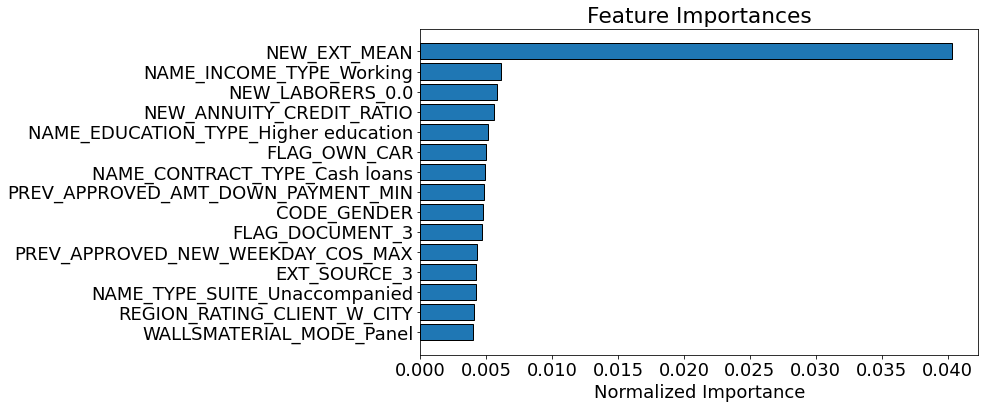

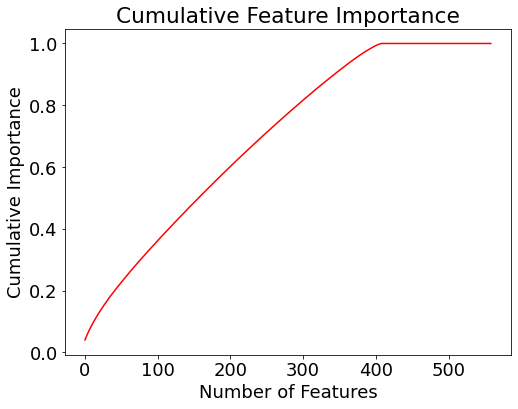

344 features required for 0.90 of cumulative importance


In [25]:
norm_feature_importances = plot_feature_importances(df4)

In [26]:
X_train = X_train.drop(columns = zero_features)
X_test = X_test.drop(columns = zero_features)

print('Training shape: ', X_train.shape)
print('Testing shape: ', X_test.shape)

Training shape:  (215253, 410)
Testing shape:  (92252, 410)


In [27]:
def identify_zero_importance_features(X, y, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    x_train : dataframe
        Training features
        
    x_test : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X_train.shape[1])

    # Create the model with several hyperparameters
    model = XGBClassifier(max_depth=6, n_estimators=120)
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Train using early stopping
        model.fit(X_train, y_train)
        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations

            
    feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [28]:
second_round_zero_features, feature_importances = identify_zero_importance_features(X, y)


There are 13 features with 0.0 importance


In [ ]:
X_train = X_train.drop(columns = zero_features)
X_test = X_test.drop(columns = zero_features)

print('Training shape: ', X_train.shape)
print('Testing shape: ', X_test.shape)

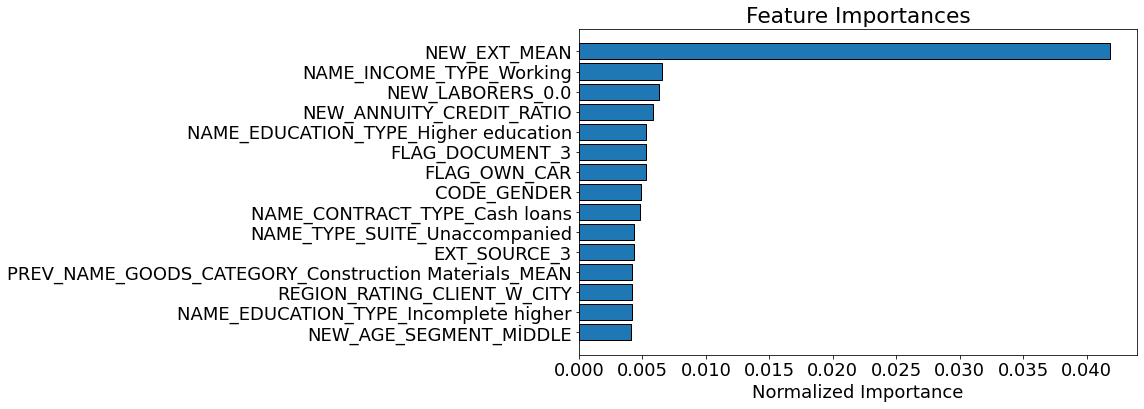

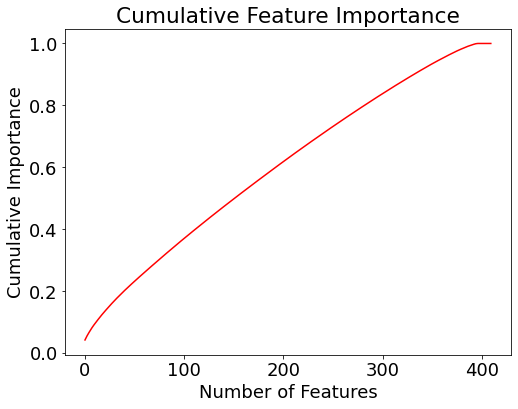

360 features required for 0.95 of cumulative importance


In [30]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [34]:
df3 = pd.DataFrame()
df3['predict']= XGB_model.predict_proba(X_scale_test)[:,1]

Text(0.5, 1.0, "Graphique des probabibilités d'affectation")

<Figure size 432x288 with 0 Axes>

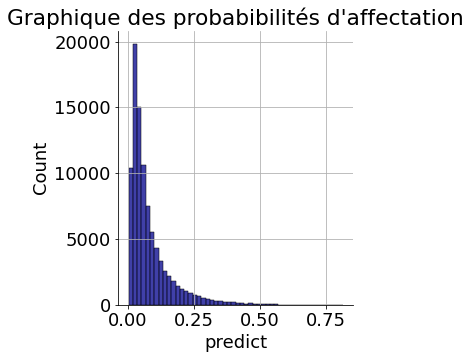

In [36]:
plt.figure()
Histo('predict',df3, 50)
plt.title('Graphique des probabibilités d\'affectation')

In [37]:
#prédiction
#y_pred = model_best.predict(X_scale_test)
#on va prendre la deuxieme colonne qui est le score de présence 
#model_best.predict_proba(X_scale_test)[:,1]>0.5
r=XGB_model.predict_proba(X_scale_test)[:,1]
y_predX=np.array(r>0.1,dtype=int)

Text(0.5, 1.0, 'Graph probability / XGB')

<Figure size 432x288 with 0 Axes>

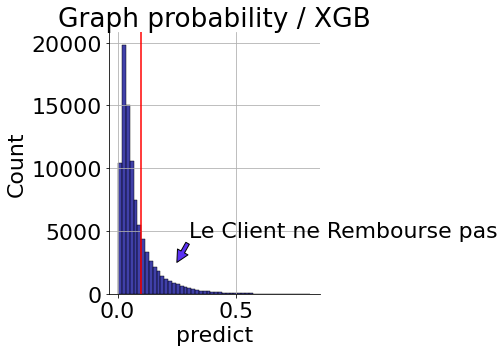

In [88]:
plt.figure()
Histo('predict',df3, 50)
plt.axvline(x=0.1, color='red')
plt.annotate('Le Client ne Rembourse pas',xy=(0.25,2500),xytext=(0.3,4500),arrowprops=
             {'facecolor':'#5930F2'})
plt.title('Graph probability / XGB')

In [40]:
logi_confusion = me.confusion_matrix(y_test, y_predX)

In [41]:
print(logi_confusion)

[[65804 19072]
 [ 3011  4365]]


In [47]:
print(classification_report(y_test, y_predX))

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     84876
         1.0       0.19      0.59      0.28      7376

    accuracy                           0.76     92252
   macro avg       0.57      0.68      0.57     92252
weighted avg       0.89      0.76      0.81     92252



In [49]:
score_XG=customScore(y_test, y_predX)
#notre scorer
score_XG

7829.300000000001

In [56]:
precisionXG=accuracy_score(y_test, y_predX)
precisionXG

0.7606230759224732

In [57]:
rappel_XG=recall_score(y_test, y_predX)
rappel_XG

0.5917841648590022

In [50]:
cls_labels_transform = conf_mat_transform(y_test, y_predX)
conf_mat = me.confusion_matrix(y_test, y_predX)
print(conf_mat)
print()
print(me.classification_report(y_test, y_predX))
#accuracy =precision la plus part sont prédits positifs et le sont effectivement
#recall=sensibilte taux de vrais positifs 
#specifite =taux de varais negatifs

[[65804 19072]
 [ 3011  4365]]

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     84876
         1.0       0.19      0.59      0.28      7376

    accuracy                           0.76     92252
   macro avg       0.57      0.68      0.57     92252
weighted avg       0.89      0.76      0.81     92252



Text(13.999999999999996, 0.5, 'Predict')

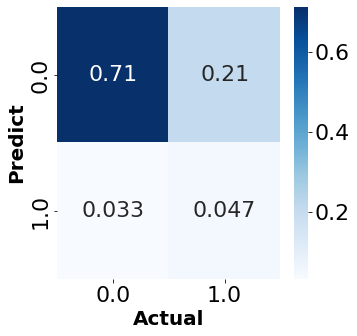

In [52]:
df_cm = pd.DataFrame(conf_mat/y_test.shape[0], index = [label for label in data_clean['TARGET'].value_counts().index ],
                  columns = [i for i in data_clean['TARGET'].value_counts().index ])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel('Actual',fontsize = 20, fontweight = 'bold')
plt.ylabel('Predict',fontsize = 20, fontweight = 'bold')

,thr,tpr,fpr
0,1.811568,0.000000,0.000000
1,0.811568,0.000136,0.000000
2,0.759646,0.000136,0.000012
3,0.712716,0.000949,0.000012
4,0.706704,0.000949,0.000024
...,...,...,...
12925,0.006843,0.999729,0.995676
12926,0.006838,0.999864,0.995676
12927,0.005403,0.999864,0.998645
12928,0.005394,1.000000,0.998645


AUC : 0.7584794628368919


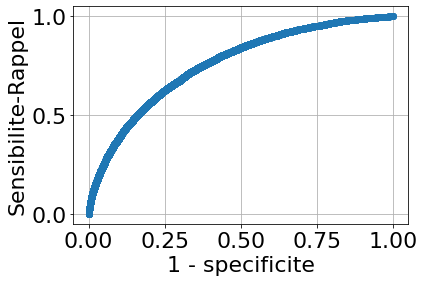

In [54]:
from sklearn.metrics import roc_auc_score
[fpr, tpr, thr]  = me.roc_curve(y_test, XGB_model.predict_proba(X_scale_test)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
AUROCXG=roc_auc_score(y_test, XGB_model.predict_proba(X_scale_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, XGB_model.predict_proba(X_scale_test)[:, 1])))

In [55]:
AUROCXG

0.7584794628368919

In [62]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

In [66]:
f1_score_XG = fbeta_score(y_test, y_predX, beta=1)
f5_score_XG = fbeta_score(y_test, y_predX, beta=5)

In [75]:
f10_score_XG = fbeta_score(y_test, y_predX, beta=10)

In [67]:

f1_score_XG

0.28332197449128615

In [68]:

f5_score_XG

0.5460529164681939

In [76]:
f10_score_XG

0.5792950934054455

In [77]:
resultat3=pd.DataFrame({'index' : [3], 'Model': ['XG Boost'],'Score':[score_XG/100], 'f1': [f1_score_XG*100], 'f5': [f5_score_XG*100], 'f10': [f10_score_XG*100],
                      'AUROC':[AUROCXG*100],'Precision':[precisionXG*100],'Recall':[rappel_XG]})

In [78]:
resultat3

,index,Model,Score,f1,f5,f10,AUROC,Precision,Recall
0,3,XG Boost,78.293,28.332197,54.605292,57.929509,75.847946,76.062308,0.591784


In [79]:
resultat3.to_csv('/content/drive/MyDrive/p7/data/res_XGB.csv', index=False)